# Case-Based Reasoning (CBR) — Integrating Textual Narratives and Biomarker Profiles

**Author:** Pranshu Goyal  
**Date:** 2025-08-16  
**Python Environment:** ≥ 3.10

---

## Abstract
This notebook presents a reproducible **Case-Based Reasoning (CBR) framework** tailored for clinical research and diagnostic support. The pipeline integrates **unstructured clinical narratives** and **structured biomarker measurements** into a unified retrieval and reasoning system. The two principal components are:

- **Semantic retrieval** of clinical narratives using a *Sentence-Transformers encoder* in combination with a *FAISS inner-product index* for scalable similarity search.  
- **Biomarker profile matching** via a *Bayesian Cluster Model (BCM)*, which leverages K-Means prototypes and Gaussian approximations to provide probabilistic alignment between patient biomarker profiles.

The system supports the complete lifecycle of experimentation, including **training**, **artifact persistence and reload**, **benchmarking** (Top-1 accuracy and latency), and a **standalone retrieval API** for querying new patient cases. In the absence of a pre-existing dataset, a small synthetic library is generated to ensure end-to-end executability.

CBR has long been studied as an effective paradigm for medical decision support, particularly for problems involving heterogeneous clinical evidence. Recent studies highlight the value of CBR in oncology and precision medicine, showing that integrating structured and unstructured data improves retrieval quality and diagnostic explainability [1], [2]. This notebook contributes a non-LLM but extensible framework that can serve as a baseline for hybrid or LLM-augmented systems.

---

## Execution Guide
1. Run all cells sequentially (*“Run All”*).  
2. Dependencies will be installed and execution paths initialised.  
3. If a dataset is available, it will be loaded; otherwise, a synthetic dataset will be generated.  
4. The pipeline will either **train** new models (if no prior artifacts exist) or **load** existing artifacts from disk.  
5. Benchmarking procedures will evaluate performance, followed by a demonstration of retrieval on a synthetic query case.  
6. All trained artifacts (models, scaler, and processed data) are persisted under the `./results/` directory for reproducibility and reuse.

In [1]:
# ==============================
# Environment Setup 
# ==============================

# %pip install -U -qq \
#   numpy==1.26.4 \
#   pandas==2.2.3 \
#   scipy==1.11.4 \
#   scikit-learn==1.5.2 \
#   torch==2.4.1 \
#   torchvision>=0.17,<1.0 \
#   sentence-transformers==3.0.1 \
#   transformers \
#   matplotlib==3.9.2 \
#   joblib==1.4.2 \
#   pillow>=10,<12 \
#   Faker

# print("Pip Dependencies Installed Successfully.")

# %conda install -y -q -c conda-forge faiss-cpu=1.7.4

# print("Conda Dependencies Installed Successfully.")

In [2]:
# ==============================
# Imports 
# ==============================

# --- Warnings ---
import warnings
from sklearn.exceptions import InconsistentVersionWarning
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)

# --- Standard library imports -------------------------
import json
import os
import random
import sys
import time
from pathlib import Path
from typing import List, Optional, Sequence, Tuple
from IPython.display import display as Display

# --- Third-party imports ------------------------------
import faiss
import joblib
import numpy as np
import pandas as pd
import torch
from IPython.display import display
from faker import Faker
from scipy.stats import multivariate_normal
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# ----------------------Minimal visuals----------------------------
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
try:
    from tqdm import tqdm
    _TQDM = True
except Exception:
    _TQDM = False

# --- Configuration & reproducibility ------------------------------
DATA_DIR = Path(os.getenv("DATA_DIR", "data")).resolve()
RESULT_DIR = Path(os.getenv("RESULT_DIR", "results")).resolve()
RANDOM_STATE = int(os.getenv("RANDOM_SEED", "42"))
AUTHOR = os.getenv("AUTHOR", "Anonymous")
DATASET = os.getenv("DATASET", "CBR_Case_library.csv")
DATA_PATH = os.path.join(DATA_DIR, DATASET)

TARGET_COL = "diagnosis"
TEXT_COL = "clinical_narrative"

os.makedirs(RESULT_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
fake = Faker()

# Suppress noisy future warnings for a cleaner notebook experience
warnings.simplefilter(action="ignore", category=FutureWarning)

# Silence a common PyTorch elastic redirect note in some environments
os.environ["TORCHELASTIC_DISABLE_REDIRECTS"] = "1"

print("Setup complete. Libraries and directories are ready.")
print(f"Python: {sys.version.split()[0]}")
print(f"PyTorch: {torch.__version__}")

/Users/pranshugoyal/anaconda3/envs/AI-Thesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup complete. Libraries and directories are ready.
Python: 3.10.14
PyTorch: 2.8.0


---
## Data Loading / Generation
This section loads the synthetic case library from disk. If the dataset is missing, a small **synthetic dataset** is generated to enable end-to-end runs.

**Schema (minimum):**
* `case_id` *(int)* — unique row identifier  
* `age`, `Cyfra21-1`, `MMP9`, `IL-6` *(float)* — example numeric biomarkers  
* `clinical_narrative` *(str)* — free-text summary  
* `diagnosis` *(str)* — class label used for benchmarking/stratification


In [3]:
TARGET_COL = 'diagnosis'
TEXT_COL = 'clinical_narrative'

def load_synthetic_case_library(data_path):
    """
    Loads the synthetic case library dataset from disk.
    Returns a pandas DataFrame.
    """
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Dataset not found at: {data_path}\n"
                                f"Please generate it first.")

    df = pd.read_csv(data_path)
    print(f"Loaded dataset from {data_path} with shape {df.shape}.")
    return df

# --- Usage ---
df = load_synthetic_case_library(DATA_PATH)

# Preview first few rows
Display(df.head(5))

Loaded dataset from /Users/pranshugoyal/Downloads/1/Case Based Reasoning Final/data/CBR_Case_library.csv with shape (10000, 79).


,case_id,age,sex,ethnicity,smoker,alcohol_user,ctDNA_Blood,miR21_Blood,miR21_Saliva,miR31_Blood,...,lncRNA_Saliva,hTERT_Blood,Zinc_Blood,Zinc_Saliva,Copper_Blood,Selenium_Blood,tnm_stage,tumor_location,clinical_narrative,diagnosis
0,0,20,Female,MIDDLE EASTERN,False,False,NaN,9.311,9.298,10.397,...,NaN,8.393,13.587,8.125,9.565,12.234,NaN,NaN,ADMISSION DATE: 2025-04-10\nCHIEF COMPLAINT: 2...,Healthy
1,1,39,Male,HISPANIC,True,False,NaN,NaN,NaN,14.379,...,12.494,NaN,12.959,14.140,9.303,12.347,NaN,left tonsillar pillar,ADMISSION DATE: 2025-07-04\nCHIEF COMPLAINT: 3...,Benign Lesion
2,2,37,Female,OTHER,False,False,13.049,9.515,9.402,11.392,...,NaN,10.509,11.219,13.459,NaN,8.300,NaN,NaN,ADMISSION DATE: 2024-11-20\nCHIEF COMPLAINT: 3...,Healthy
3,3,20,Female,NATIVE AMERICAN,True,True,NaN,NaN,9.663,NaN,...,12.998,12.101,10.730,11.346,11.471,8.684,NaN,NaN,ADMISSION DATE: 2024-10-06\nCHIEF COMPLAINT: 2...,Healthy
4,4,35,Female,ASIAN,False,False,NaN,9.255,11.163,10.734,...,14.675,10.360,10.742,12.356,11.197,13.079,NaN,floor of mouth,ADMISSION DATE: 2025-02-18\nCHIEF COMPLAINT: 3...,Benign Lesion


---
## Visual Diagnostics (helpers)

This section defines several helper functions for **visualising diagnostic information** related to datasets, clustering, benchmarking, retrieval scores, and feature comparison.  
The functions rely on `matplotlib`, `numpy`, `pandas`, and `sklearn` utilities to generate informative plots.

In [4]:
# ==============================
# Visual Diagnostics (helpers)
# ==============================

def show_dataset_overview(df: pd.DataFrame, target_col: str = "diagnosis"):
    """
    Generates bar charts for:
      1. Class balance of the target column.
      2. Missingness in numeric features.
    Provides quick read-only visual diagnostics on dataset quality.
    """
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))

    # ---- Class balance (proportion of each label in target_col) ----
    df[target_col].value_counts(normalize=True).sort_index().plot(kind="bar", ax=axes[0])
    axes[0].set_title("Class Balance (proportion)")
    axes[0].set_xlabel("Class")
    axes[0].set_ylabel("Proportion")

    # ---- Missingness in numeric columns (top 15 features only) ----
    miss = df.select_dtypes(include=[float, int]).isna().mean().sort_values(ascending=False).head(15)
    miss.plot(kind="bar", ax=axes[1])
    axes[1].set_title("Top-15 Numeric Columns by Missingness")
    axes[1].set_xlabel("Feature")
    axes[1].set_ylabel("Fraction Missing")

    # Ensure plots are neatly arranged and rendered
    plt.tight_layout()
    plt.show()

def plot_bcm_clusters(engine: "UnifiedCBREngine"):
    """
    Plots a 2D PCA projection of the structured feature space
    with K-Means centroids (prototypes) overlaid.
    
    - Reduces high-dimensional data into 2D (via PCA).
    - Colours represent cluster assignments.
    - Cluster centroids are shown with 'X' markers and labelled as Pi.
    """
    X = engine.library_scaled[engine.structured_cols].values
    labels = engine.bcm.kmeans.predict(X)

    pca = PCA(n_components=2, random_state=42)
    X2 = pca.fit_transform(X)
    centers2 = pca.transform(engine.bcm.kmeans.cluster_centers_)

    plt.figure(figsize=(6.5, 5.5))
    plt.scatter(X2[:, 0], X2[:, 1], c=labels, s=6, alpha=0.5)
    plt.scatter(centers2[:, 0], centers2[:, 1], marker="X", s=120, edgecolor="k")
    for i, (cx, cy) in enumerate(centers2):
        plt.text(cx, cy, f"P{i}", fontsize=9, ha="center", va="center")
    plt.title("BCM: PCA Projection of Structured Feature Space")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

def plot_benchmark(results_df: pd.DataFrame):
    """
    Visualises benchmarking results:
      - Top-1 Accuracy (normalised to 0–1 scale).
      - Average latency (milliseconds).
    
    Each configuration is compared via side-by-side bar plots.
    """
    df_plot = results_df.copy()
    df_plot["Top-1 Accuracy (float)"] = df_plot["Top-1 Accuracy"].str.rstrip("%").astype(float) / 100.0
    df_plot["Avg. Latency (ms)"] = df_plot["Avg. Latency (ms)"].astype(float)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # ---- Left plot: Accuracy ----
    axes[0].bar(df_plot["Configuration"], df_plot["Top-1 Accuracy (float)"])
    axes[0].set_title("Top-1 Accuracy")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_ylim(0, 1)

    # ---- Right plot: Latency ----
    axes[1].bar(df_plot["Configuration"], df_plot["Avg. Latency (ms)"])
    axes[1].set_title("Average Latency (ms)")
    axes[1].set_ylabel("ms")

    # Rotate x-axis labels slightly for readability
    for ax in axes:
        ax.set_xlabel("")
        for tick in ax.get_xticklabels():
            tick.set_rotation(15)

    plt.tight_layout()
    plt.show()

def plot_retrieved_scores(retrieved_df: pd.DataFrame, k: int = 10):
    """
    Displays combined view of scores for the top-k retrieved cases:
      - Bar chart for final_score.
      - Line plots for text_similarity and bcm_prob.
    
    Useful for evaluating retrieval quality and scoring behaviour.
    """
    if retrieved_df is None or retrieved_df.empty:
        print("No retrieved cases to plot.")
        return

    # Take top-k rows and prepare relevant columns
    dfp = retrieved_df.head(k).copy()
    dfp["case_id"] = dfp.index.astype(int)
    dfp = dfp[["case_id", "final_score", "text_similarity", "bcm_prob"]]

    fig, ax = plt.subplots(figsize=(7, 4.5))
    x = np.arange(len(dfp))

    # ---- Bar for final_score ----
    ax.bar(x, dfp["final_score"], label="final_score")

    # ---- Lines for similarity/probability ----
    ax.plot(x, dfp["text_similarity"], marker="o", label="text_similarity")
    ax.plot(x, dfp["bcm_prob"], marker="s", label="bcm_prob")

    # Titles and labels
    ax.set_title("Top-k Retrieved: Scores Breakdown")
    ax.set_xlabel("Ranked cases")
    ax.set_xticks(x)
    ax.set_xticklabels([str(i) for i in dfp["case_id"]], rotation=0)
    ax.set_ylabel("Score")
    ax.legend()

    plt.tight_layout()
    plt.show()

def plot_rationale_heatmap(query_case: dict, retrieved_df: pd.DataFrame, structured_cols: Sequence[str]):
    """
    Creates a heatmap comparing numeric features between:
      - The query case.
      - The top retrieved case.
      - Their absolute differences.
    
    Helps explain retrieval rationale by highlighting feature-level
    similarities and deviations.
    """
    if retrieved_df is None or retrieved_df.empty:
        print("No retrieved cases.")
        return

    # Extract top match from retrieved cases
    top = retrieved_df.iloc[0]

    # Collect query and top values for numeric structured columns
    q_vals = [float(query_case.get(c, np.nan)) for c in structured_cols]
    t_vals = [float(top.get(c, np.nan)) for c in structured_cols]
    diff = [abs(q - t) if (np.isfinite(q) and np.isfinite(t)) else np.nan for q, t in zip(q_vals, t_vals)]

    # Construct heatmap data
    data = np.array([q_vals, t_vals, diff])
    plt.figure(figsize=(max(6, len(structured_cols) * 0.4), 3.6))
    plt.imshow(data, aspect="auto")

    # Set y-axis rows for Query, Top Match, and Difference
    plt.yticks([0, 1, 2], ["Query", "Top Match", "|Diff|"])
    plt.xticks(range(len(structured_cols)), structured_cols, rotation=45, ha="right")

    # Titles and colour bar
    plt.title("Query vs Top Match — Numeric Feature Comparison")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

---
## Model Modules
We define three core components:

1. **`BCMModule`** 
2. **`TextCBRModule`** 
3. **`UnifiedCBREngine`**

We also include utility functions for artifact **save/load**.


---
## BCMModule — Bayesian Cluster Model Helper

This class implements a **Bayesian Cluster Model (BCM)** built on top of **K-Means prototypes** for numeric features.  
It combines clustering, Gaussian approximation, probability estimation, and explainability utilities.  
Below is the annotated source code with detailed explanations.

*Implementation details and code follow in subsequent cells.*

In [5]:
class BCMModule:
    """
    Bayesian Cluster Model (BCM) over numeric features using K-Means prototypes.

    * `fit` learns cluster centers and per-cluster Gaussian approximations.
    * `predict_proba` returns normalized prototype likelihoods for a given vector.
    * `explain` provides a simple per-feature comparison between query and prototype means.
    """

    def __init__(self, n_prototypes: int = 6) -> None:
        # Initialise with a fixed number of prototypes (clusters).
        self.n_prototypes = int(n_prototypes)
        # KMeans is used to discover prototype centroids.
        self.kmeans = KMeans(n_clusters=self.n_prototypes, random_state=42, n_init=10)
        # Stores learned prototypes (id, anchor case, Gaussian stats, priors).
        self.prototypes_: List[dict] = []

    def fit(self, structured_df: pd.DataFrame, original_df: pd.DataFrame) -> None:
        """
        Fit the BCM:
          - Run KMeans clustering on numeric features.
          - For each cluster, compute mean, covariance, prior, and anchor case.
          - Store results in `self.prototypes_`.
        """
        print(f"BCM: Learning {self.n_prototypes} prototypes...")
        structured_np = structured_df.values
        labels = self.kmeans.fit_predict(structured_np)
        self.prototypes_.clear()

        # ---- Build prototype info for each cluster ----
        for i in range(self.n_prototypes):
            cluster_mask = labels == i
            cluster_df = structured_df[cluster_mask]
            cluster_np = cluster_df.values

            # Centroid and anchor case (closest case to centroid).
            centroid = self.kmeans.cluster_centers_[i]
            dists = euclidean_distances(cluster_np, centroid.reshape(1, -1))
            anchor_local_idx = int(np.argmin(dists))
            anchor_global_idx = int(cluster_df.index[anchor_local_idx])
            anchor_case = original_df.loc[anchor_global_idx]

            # Gaussian stats: mean & covariance matrix (+ jitter for numerical stability).
            mean = np.mean(cluster_np, axis=0)
            cov = np.cov(cluster_np.T) + np.eye(cluster_np.shape[1]) * 1e-6
            # Prior: cluster size as fraction of dataset.
            prior = len(cluster_np) / max(1, len(structured_np))

            # Store prototype metadata.
            self.prototypes_.append(
                {
                    "id": int(i),
                    "name": f"P{i}: {anchor_case[TARGET_COL]} ({cluster_mask.sum()} cases)",
                    "anchor_case_id": int(anchor_case["case_id"]) if "case_id" in anchor_case else int(anchor_global_idx),
                    "diagnosis_label": anchor_case[TARGET_COL],
                    "mean": mean,
                    "cov": cov,
                    "prior": float(prior),
                }
            )
        print("BCM: Prototype learning complete.")

    def save(self, path: str) -> None:
        """
        Save model state:
          - KMeans object.
          - Prototypes list.
        """
        os.makedirs(path, exist_ok=True)
        joblib.dump(self.kmeans, os.path.join(path, "kmeans.joblib"))
        joblib.dump(self.prototypes_, os.path.join(path, "prototypes.joblib"))
        print(f"BCMModule saved to {path}")

    @classmethod
    def load(cls, path: str) -> Optional["BCMModule"]:
        """
        Load model state from disk:
          - If required files exist, restore KMeans and prototypes.
          - Returns an instance of BCMModule or None.
        """
        kmeans_path = os.path.join(path, "kmeans.joblib")
        prototypes_path = os.path.join(path, "prototypes.joblib")
        if not (os.path.exists(kmeans_path) and os.path.exists(prototypes_path)):
            return None
        instance = cls()
        instance.kmeans = joblib.load(kmeans_path)
        instance.prototypes_ = joblib.load(prototypes_path)
        instance.n_prototypes = len(instance.prototypes_)
        print(f"BCMModule loaded from {path}")
        return instance

    def predict_proba(self, vector: np.ndarray) -> np.ndarray:
        """
        Compute per-prototype likelihoods for a given **scaled** input vector.

        - Uses multivariate Gaussian PDF for each prototype.
        - Multiplies likelihoods with cluster priors.
        - Normalises to ensure probabilities sum to 1.
        """
        if not self.prototypes_:
            return np.zeros(self.n_prototypes, dtype=float)

        # Likelihood under each prototype Gaussian.
        likelihoods = np.array(
            [multivariate_normal.pdf(vector, mean=p["mean"], cov=p["cov"]) for p in self.prototypes_],
            dtype=float,
        )
        # Priors: relative cluster size.
        priors = np.array([p["prior"] for p in self.prototypes_], dtype=float)
        evidence = float(np.sum(likelihoods * priors))

        # Bayes rule normalisation.
        return (likelihoods * priors) / evidence if evidence > 0 else np.zeros(self.n_prototypes, dtype=float)

    def explain(
        self,
        query_vector: np.ndarray,
        prototype_id: int,
        scaler: MinMaxScaler,
        columns: Sequence[str],
    ) -> str:
        """
        Provide an explanation for why a query matches a prototype:

        - Unscales query and prototype mean values.
        - Prints side-by-side feature comparisons.
        """
        proto = self.prototypes_[int(prototype_id)]
        query_unscaled = scaler.inverse_transform(query_vector.reshape(1, -1))[0]
        proto_mean_unscaled = scaler.inverse_transform(proto["mean"].reshape(1, -1))[0]

        lines = [f"Matches Prototype '{proto['name']}'. Key feature comparison:"]
        for i, col in enumerate(columns):
            lines.append(f"  - {col}: Query={query_unscaled[i]:.2f}, Proto Avg={proto_mean_unscaled[i]:.2f}")
        return "\n".join(lines)

---
## TextCBRModule — Case-Based Reasoning for Clinical Narratives

This class implements a **text-based Case-Based Reasoning (CBR) module**.  
It leverages **SentenceTransformers** for encoding clinical narratives into dense embeddings, and **FAISS** for efficient similarity search using an inner-product index.  

The module provides methods for **building an index**, **saving/loading state**, and **retrieving similar cases** given a query text.  

In [6]:
class TextCBRModule:
    """
    Encodes clinical narratives and builds a FAISS inner-product index for fast retrieval.
    """

    def __init__(self, model_name: str = "all-MiniLM-L6-v2") -> None:
        # Initialise with a pretrained SentenceTransformer model.
        self.model_name = model_name
        self.model = SentenceTransformer(self.model_name)
        # Embedding dimension of the chosen model (needed for FAISS index construction).
        self.embedding_dim = int(self.model.get_sentence_embedding_dimension())
        # FAISS index will be created after embeddings are built.
        self.index: Optional[faiss.IndexFlatIP] = None
        # Mapping of case IDs to maintain correspondence between index and dataset.
        self.case_ids: List[int] = []

    def build_index(self, case_library_df: pd.DataFrame) -> None:
        """
        Build the FAISS index from a dataframe of clinical cases.
          - Extract narratives (TEXT_COL).
          - Encode them into embeddings.
          - Normalise and add to FAISS inner-product index.
        """
        print("TextCBR: Encoding text and building FAISS index...")
        narratives = case_library_df[TEXT_COL].astype(str).tolist()
        self.case_ids = case_library_df["case_id"].astype(int).tolist()

        # Encode narratives into dense vectors using SentenceTransformer.
        embeddings = self.model.encode(narratives, show_progress_bar=True, convert_to_numpy=True)

        # Build FAISS index with inner-product metric.
        self.index = faiss.IndexFlatIP(self.embedding_dim)
        faiss.normalize_L2(embeddings)  # L2 normalisation for cosine similarity equivalence.
        self.index.add(embeddings)
        print(f"TextCBR: FAISS index built with {int(self.index.ntotal)} cases.")

    def save(self, path: str) -> None:
        """
        Save the module state to disk:
          - FAISS index file.
          - Metadata (case IDs, model name).
        """
        os.makedirs(path, exist_ok=True)
        if self.index is None:
            raise RuntimeError("Cannot save TextCBRModule before building the index.")
        faiss.write_index(self.index, os.path.join(path, "faiss.index"))
        metadata = {"case_ids": self.case_ids, "model_name": self.model_name}
        with open(os.path.join(path, "metadata.json"), "w", encoding="utf-8") as f:
            json.dump(metadata, f)
        print(f"TextCBRModule saved to {path}")

    @classmethod
    def load(cls, path: str) -> Optional["TextCBRModule"]:
        """
        Load a previously saved module:
          - Restores SentenceTransformer encoder.
          - Loads FAISS index and case ID mapping.
        """
        metadata_path = os.path.join(path, "metadata.json")
        index_path = os.path.join(path, "faiss.index")
        if not (os.path.exists(metadata_path) and os.path.exists(index_path)):
            return None

        # Load metadata (model name + case IDs).
        with open(metadata_path, "r", encoding="utf-8") as f:
            metadata = json.load(f)

        # Create instance and restore components.
        instance = cls(model_name=metadata["model_name"])  # Loads encoder.
        instance.index = faiss.read_index(index_path)
        instance.case_ids = [int(x) for x in metadata["case_ids"]]
        print(f"TextCBRModule loaded from {path}")
        return instance

    def retrieve(self, query_text: str, k: int = 20) -> Tuple[List[int], np.ndarray]:
        """
        Retrieve top-k most similar cases for a given query:
          - Encode query into embedding.
          - Search FAISS index for top-k matches.
          - Return (case_ids, similarity scores).
        """
        if self.index is None:
            return [], np.array([])

        # Encode and normalise the query embedding.
        query_embedding = self.model.encode([str(query_text)], convert_to_numpy=True)
        faiss.normalize_L2(query_embedding)

        # Search top-k matches in FAISS index.
        distances, indices = self.index.search(query_embedding, k)

        # Map indices back to case IDs.
        case_ids = [self.case_ids[i] for i in indices[0] if 0 <= i < len(self.case_ids)]
        return case_ids, distances[0]

---
## UnifiedCBREngine — Combined Text + Structured Case-Based Reasoning

This class **orchestrates hybrid case retrieval** by combining:  
1. **Text-based retrieval** using the `TextCBRModule` (semantic similarity of clinical narratives).  
2. **BCM (Bayesian Cluster Model) re-ranking** using structured numeric features.  

It allows **multi-modal case retrieval** by weighting both sources of evidence (text + structured features) and returning a ranked list of candidate cases.  


In [7]:
class UnifiedCBREngine:
    """
    Orchestrates Text-first retrieval and BCM re-ranking over structured features.
    """

    def __init__(
        self,
        bcm_module: BCMModule,
        text_module: TextCBRModule,
        case_library: pd.DataFrame,
        scaler: MinMaxScaler,
        structured_cols: Sequence[str],
    ) -> None:
        # Save references to BCM and TextCBR modules.
        self.bcm = bcm_module
        self.text = text_module

        # Case library indexed by case_id for quick lookup.
        self.library = case_library.set_index("case_id")

        # Scaler to normalise structured numeric features.
        self.scaler = scaler
        self.structured_cols = list(structured_cols)

        # Store a scaled version of structured features for BCM scoring.
        self.library_scaled = self.library.copy()
        self.library_scaled[self.structured_cols] = self.scaler.transform(
            self.library[self.structured_cols]
        )

    def retrieve_and_rank(
        self,
        query_case: pd.Series,
        k_text: int = 20,
        k_final: int = 3,
        w_text: float = 0.4,
        w_bcm: float = 0.6,
    ) -> Tuple[pd.DataFrame, float]:
        """
        Main retrieval pipeline:
          1. Stage 1: Use TextCBR to retrieve top-k_text candidates by semantic similarity.
          2. Stage 2: For those candidates, compute BCM probabilities using structured features.
          3. Combine both scores with weights (w_text, w_bcm) to get a final ranking.
          4. Return top-k_final ranked cases + retrieval latency (ms).
        """
        start = time.time()

        # ---- Stage 1: Text-based retrieval ----
        candidate_ids, text_scores = self.text.retrieve(query_case.get(TEXT_COL, ""), k=k_text)
        if not candidate_ids:
            return pd.DataFrame(), 0.0

        # Construct candidate subset and attach text similarity scores.
        candidates_df = self.library.loc[candidate_ids].copy()
        candidates_df["text_similarity"] = text_scores

        # ---- Stage 2: BCM scoring (structured features) ----
        # Scale query case's structured numeric features.
        query_struct_df = pd.DataFrame([query_case])[self.structured_cols]
        query_struct_scaled = self.scaler.transform(query_struct_df)[0]

        bcm_scores: List[float] = []
        bcm_explanations: List[str] = []

        # For each candidate case:
        for cid, cand_row in candidates_df.iterrows():
            # Get structured features (scaled).
            cand_struct_scaled = self.library_scaled.loc[cid][self.structured_cols].values

            # Compute posterior probabilities from BCM.
            posteriors = self.bcm.predict_proba(cand_struct_scaled)

            # Pick the prototype with the highest posterior probability.
            best_proto_id = int(np.argmax(posteriors))
            bcm_scores.append(float(posteriors[best_proto_id]))

            # Generate explanation for this prototype match.
            bcm_explanations.append(
                self.bcm.explain(query_struct_scaled, best_proto_id, self.scaler, self.structured_cols)
            )

        # Attach BCM results to candidates dataframe.
        candidates_df["bcm_prob"] = bcm_scores
        candidates_df["bcm_explanation"] = bcm_explanations

        # ---- Stage 3: Weighted combination ----
        candidates_df["final_score"] = (
            float(w_text) * candidates_df["text_similarity"] + float(w_bcm) * candidates_df["bcm_prob"]
        )

        # Rank candidates by final_score (descending).
        ranked = candidates_df.sort_values(by="final_score", ascending=False)

        # Compute latency in ms.
        latency_ms = (time.time() - start) * 1000.0
        return ranked.head(k_final), float(latency_ms)

---
## System Persistence & Diagnostic Rationale

This section provides three main utilities:  

1. **save_system_artifacts** → Saves all trained components (BCM, TextCBR, scaler, training dataset, and structured columns) to disk.  
2. **load_cbr_engine_from_disk** → Loads the saved artifacts and reassembles a working `UnifiedCBREngine`.  
3. **generate_rationale_report** → Produces a pretty-printed report comparing a query case with its top retrieved match, including textual and structured (BCM) reasoning.  

These functions ensure reproducibility, persistence, and interpretability of the case-based reasoning system.

In [8]:
def save_system_artifacts(
    result_dir: str,
    bcm_model: BCMModule,
    text_cbr_model: TextCBRModule,
    scaler: MinMaxScaler,
    train_df: pd.DataFrame,
    numeric_structured_cols: Sequence[str],
) -> None:
    """Persist all components atomically."""
    # Define paths for all artifacts
    bcm_path = os.path.join(result_dir, "bcm_module")
    text_cbr_path = os.path.join(result_dir, "text_cbr_module")
    scaler_path = os.path.join(result_dir, "scaler.joblib")
    train_df_path = os.path.join(result_dir, "case_library_train.csv")
    numeric_cols_path = os.path.join(result_dir, "numeric_structured_cols.json")

    print("\n--- Saving all system artifacts to disk... ---")
    # Save models, scaler, training data, and numeric feature names
    bcm_model.save(bcm_path)
    text_cbr_model.save(text_cbr_path)
    joblib.dump(scaler, scaler_path)
    train_df.to_csv(train_df_path, index=False)
    with open(numeric_cols_path, "w", encoding="utf-8") as f:
        json.dump(list(numeric_structured_cols), f)
    print("Artifacts saved.")

def load_cbr_engine_from_disk(result_dir: str) -> UnifiedCBREngine:
    """
    Load all components and assemble a `UnifiedCBREngine`.
    """
    print("\n" + "=" * 80)
    print("          Loading CBR System Components from Disk")
    print("=" * 80)

    # Define paths for artifacts
    bcm_path = os.path.join(result_dir, "bcm_module")
    text_cbr_path = os.path.join(result_dir, "text_cbr_module")
    scaler_path = os.path.join(result_dir, "scaler.joblib")
    train_df_path = os.path.join(result_dir, "case_library_train.csv")
    numeric_cols_path = os.path.join(result_dir, "numeric_structured_cols.json")

    # Load each component
    bcm_model = BCMModule.load(bcm_path)
    text_cbr_model = TextCBRModule.load(text_cbr_path)
    scaler = joblib.load(scaler_path)
    train_df = pd.read_csv(train_df_path)
    with open(numeric_cols_path, "r", encoding="utf-8") as f:
        numeric_structured_cols = json.load(f)

    # Check for missing components
    if not all([bcm_model, text_cbr_model, scaler is not None, train_df is not None]):
        raise FileNotFoundError(
            "One or more essential model artifacts could not be loaded. "
            "Please ensure the system has been trained by running the training cell."
        )

    print("\nCBR Engine successfully assembled from saved artifacts.\n")
    return UnifiedCBREngine(bcm_model, text_cbr_model, train_df, scaler, numeric_structured_cols)

def generate_rationale_report(
    query_case: pd.Series, retrieved_cases: pd.DataFrame, suggested_diagnosis: str, structured_cols: Sequence[str]
) -> None:
    """Pretty-print a rationale summary comparing query vs. top match."""
    print("\n" + "=" * 80)
    print("      NON-LLM CBR DIAGNOSTIC RATIONALE REPORT (For Research Use Only)")
    print("=" * 80)

    # Suggested diagnosis from retrieval result
    print(f"\n[+] SUGGESTED DIAGNOSIS: {suggested_diagnosis} (From Top Match)")

    if retrieved_cases.empty:
        print("No matches.")
        return

    # Select top match from retrieved cases
    top_match = retrieved_cases.iloc[0]

    # Print reasoning based on text similarity + BCM probability
    print(f"\n[+] REASONING FOR TOP MATCH (Case ID: {top_match.name}):")
    print(f"  - Textual Similarity Score: {float(top_match['text_similarity']):.3f}")
    snippet = str(top_match[TEXT_COL])[:70].replace("\n", " ")
    print(f"    - Narrative: '{snippet}...'")
    print("  - Biomarker Profile Match (BCM):")
    print(f"    - Probability: {float(top_match['bcm_prob']):.3f}")

    # BCM explanation (prototype-based rationale)
    bcm_expl_indented = "    - " + str(top_match["bcm_explanation"]).replace("\n", "\n    - ")
    print(bcm_expl_indented.strip())

    # Print side-by-side comparison of structured numeric features
    print("\n--- QUERY CASE vs. TOP MATCH ---")
    print(f"{'Feature':<15} | {'Query Case':<25} | {'Top Match (Case ' + str(top_match.name) + ')':<25}")
    print("-" * 75)
    for col in structured_cols:
        qv = float(query_case[col]) if col in query_case else float("nan")
        tv = float(top_match[col]) if col in top_match else float("nan")
        print(f"{col:<15} | {qv:<25.2f} | {tv:<25.2f}")

    # Append diagnosis comparison
    print(f"{'Diagnosis':<15} | {'(New Patient)':<25} | {str(top_match[TARGET_COL]):<25}")
    print("-" * 75)    

---
## Training, Persistence, and Reload Logic

This section implements the **end-to-end training and persistence pipeline** for the Case-Based Reasoning (CBR) system.  
It handles:  

1. Training both submodules (**BCM** for structured numeric features and **TextCBR** for clinical narratives).  
2. Preparing and saving system artifacts (models, scaler, training data).  
3. Reloading existing system artifacts if already available, avoiding redundant retraining.  
4. Returning a `UnifiedCBREngine` and a held-out test split for evaluation. 

In [9]:
def train_and_save_system(data_df: pd.DataFrame, result_dir: str) -> Tuple["UnifiedCBREngine", pd.DataFrame]:
    """Full training + persistence pipeline. Returns engine and a test split."""
    print("--- Starting new system training process. This will run only once. ---")

    # ---- Dataset overview (visual) ----
    # Attempts to display class balance + missingness heatmap.
    # Skips gracefully if rendering fails (e.g., headless environment).
    try:
        show_dataset_overview(data_df, target_col=TARGET_COL)
    except Exception as _e:
        print("Dataset overview skipped (unable to render).")

    # ---- Train/test split ----
    # Stratified split ensures class distribution consistency.
    train_df, test_df = train_test_split(
        data_df, test_size=0.2, random_state=42, stratify=data_df[TARGET_COL]
    )

    # ---- Identify numeric features ----
    # Used for BCM (structured clustering). Excludes 'case_id' if numeric.
    numeric_cols = (
        train_df.select_dtypes(include=[float, int]).columns.difference(["case_id"]).tolist()
    )

    # ---- Handle missing values ----
    # Mean imputation for numeric features ensures no NaNs in training/testing.
    impute_values = train_df[numeric_cols].mean()
    train_df.loc[:, numeric_cols] = train_df[numeric_cols].fillna(impute_values)
    test_df.loc[:, numeric_cols] = test_df[numeric_cols].fillna(impute_values)

    # ---- Scaling ----
    # MinMaxScaler normalises numeric values to [0, 1].
    scaler = MinMaxScaler()
    train_df_scaled = train_df.copy()
    train_df_scaled.loc[:, numeric_cols] = scaler.fit_transform(train_df[numeric_cols])

    # ---- Train BCM ----
    # Learns prototypes over scaled numeric features.
    bcm_model = BCMModule()
    bcm_model.fit(train_df_scaled[numeric_cols], train_df)

    # ---- Train TextCBR ----
    # Encodes narratives and builds FAISS index.
    text_cbr_model = TextCBRModule()
    text_cbr_model.build_index(train_df)

    # ---- Assemble Unified Engine ----
    engine = UnifiedCBREngine(bcm_model, text_cbr_model, train_df, scaler, numeric_cols)

    # ---- Save artifacts to disk ----
    save_system_artifacts(result_dir, bcm_model, text_cbr_model, scaler, train_df, numeric_cols)

    print("\n--- System training and saving complete. Artifacts are ready. ---")
    return engine, test_df

# === Train (if needed) or Load =============================================
# NOTE: Assumes a DataFrame `df` exists with required columns:
#   - 'case_id'
#   - TARGET_COL (diagnosis label)
#   - TEXT_COL (narratives)
#   - Numeric structured features
# Ensure `df` is available in memory before running.

scaler_fp = os.path.join(RESULT_DIR, "scaler.joblib")

if not os.path.exists(scaler_fp):
    # ---- First-time training ----
    # If no saved scaler found, assume system not trained → train & persist.
    try:
        _ = df.shape
        show_dataset_overview(df, target_col=TARGET_COL)
    except NameError:
        print("df was not found; skipping dataset overview prior to training.")
    cbr_engine, test_df = train_and_save_system(df, RESULT_DIR)

else:
    # ---- Reload from disk ----
    print("System artifacts already exist. Loading artifacts from disk...")
    cbr_engine = load_cbr_engine_from_disk(RESULT_DIR)

    # Create a new evaluation split from persisted library if no external test set exists.
    base_df = cbr_engine.library.reset_index()
    _, test_df = train_test_split(
        base_df, test_size=0.2, random_state=42, stratify=base_df[TARGET_COL]
    )
    print("Engine loaded; test split prepared from saved library.")


System artifacts already exist. Loading artifacts from disk...

          Loading CBR System Components from Disk
BCMModule loaded from /Users/pranshugoyal/Downloads/1/Case Based Reasoning Final/results/bcm_module
TextCBRModule loaded from /Users/pranshugoyal/Downloads/1/Case Based Reasoning Final/results/text_cbr_module

CBR Engine successfully assembled from saved artifacts.

Engine loaded; test split prepared from saved library.


---
## Benchmarking & Evaluation Utilities

This section defines functions to **evaluate system performance** under different configurations:  

- **Text-Only** → Uses only semantic similarity (TextCBR).  
- **BCM-Re-ranked** → Uses only structured numeric re-ranking (BCM).  
- **Unified** → Combines both with weighted scoring.  

The pipeline computes **Top-1 Accuracy** and **Average Latency**, aggregates results into a dataframe, and visualises benchmarks and clustering.  


In [10]:
def evaluate_config(engine: UnifiedCBREngine, test_df: pd.DataFrame, config_name: str, target_col: str = TARGET_COL) -> Tuple[float, float]:
    """Compute Top-1 accuracy and average latency for a given configuration (visual progress if tqdm available)."""
    
    # ---- Select configuration weights ----
    if config_name == "Text-Only":
        w_text, w_bcm = 1.0, 0.0
    elif config_name == "BCM-Re-ranked":
        w_text, w_bcm = 0.0, 1.0
    else:
        # Default "Unified" mode → weighted blend
        w_text, w_bcm = 0.4, 0.6

    correct_top1 = 0        # Counter for correct predictions
    total_latency = 0.0     # Accumulator for average latency

    # Use tqdm progress bar if available
    iterator = test_df.iterrows()
    if _TQDM:
        iterator = tqdm(iterator, total=len(test_df), desc=f"Evaluating {config_name}")

    # ---- Evaluate each test case ----
    for _, test_case in iterator:
        retrieved, latency = engine.retrieve_and_rank(test_case, w_text=w_text, w_bcm=w_bcm)
        
        # Check if Top-1 retrieved case matches true label
        if not retrieved.empty and retrieved.iloc[0][target_col] == test_case[target_col]:
            correct_top1 += 1

        # Accumulate latency
        total_latency += float(latency)

    # ---- Compute metrics ----
    accuracy = correct_top1 / max(1, len(test_df))
    avg_latency = total_latency / max(1, len(test_df))
    return float(accuracy), float(avg_latency)

def run_benchmark(engine: UnifiedCBREngine, test_df: pd.DataFrame, target_col: str = TARGET_COL, display_results: bool = True) -> pd.DataFrame:
    """Runs evaluation under multiple configurations and aggregates results."""
    print("\n" + "=" * 80)
    print("           Starting Benchmarking Evaluation")
    print("=" * 80)

    # Configurations to benchmark
    configs_to_test = ["Text-Only", "BCM-Re-ranked", "Unified"]
    rows = []

    # ---- Loop through each configuration ----
    for name in configs_to_test:
        print(f"Evaluating: {name}...")
        acc, lat = evaluate_config(engine, test_df, name, target_col=target_col)
        rows.append({
            "Configuration": name,
            "Top-1 Accuracy": f"{acc:.2%}",
            "Avg. Latency (ms)": f"{lat:.2f}"
        })

    # Collect results in DataFrame
    results_df = pd.DataFrame(rows)

    # ---- Display results ----
    print("\n--- Benchmark Results ---")
    if display_results:
        try:
            display(results_df)  
        except NameError:
            print(results_df)
    else:
        print(results_df)

    return results_df

---
## Case Retrieval Pipeline (New Patient Query)

This section implements the **retrieval process for new patient cases** using the persisted Case-Based Reasoning (CBR) system.  
It handles:  

1. **Engine Loading (Lazy Init):** Ensures the `UnifiedCBREngine` is only loaded once per session and cached globally.  
2. **Query Preprocessing:** Converts input into a `pandas.Series`, imputes missing numeric values.  
3. **Retrieval & Ranking:** Calls the engine to get top-k most similar cases.  
4. **Interpretability:** Prints top match information and explanation from BCM.  
5. **Visualisation:** Provides retrieved scores breakdown and rationale heatmap for interpretability.  


--------------------------------------------------------------------------------
Initializing CBR Engine for Retrieval
--------------------------------------------------------------------------------

          Loading CBR System Components from Disk
BCMModule loaded from /Users/pranshugoyal/Downloads/1/Case Based Reasoning Final/results/bcm_module
TextCBRModule loaded from /Users/pranshugoyal/Downloads/1/Case Based Reasoning Final/results/text_cbr_module

CBR Engine successfully assembled from saved artifacts.


--------------------------------------------------------------------------------
Retrieving cases for query (preview): "Elderly patient with history of smoking presents with a larg..."
--------------------------------------------------------------------------------

Retrieval complete in 1508.68 ms.

============================== TOP MATCH ==============================
  Case ID     : 977
  Diagnosis   : OSCC
  Final Score : 0.891
  Explanation :
  Matches Prototype 'P1: OS

,age,sex,ethnicity,smoker,alcohol_user,ctDNA_Blood,miR21_Blood,miR21_Saliva,miR31_Blood,miR31_Saliva,...,Copper_Blood,Selenium_Blood,tnm_stage,tumor_location,clinical_narrative,diagnosis,text_similarity,bcm_prob,bcm_explanation,final_score
case_id,,,,,,,,,,,,,,,,,,,,,
977,60,Female,UNKNOWN,True,True,20.607,12.324,15.474000,13.644057,20.585,...,15.705000,13.873000,Stage I,floor of mouth,ADMISSION DATE: 2025-01-12\nCHIEF COMPLAINT: 6...,OSCC,0.736012,0.993702,Matches Prototype 'P1: OSCC (1066 cases)'. Key...,0.890626
696,21,Female,UNKNOWN,True,True,18.314,17.654,13.588955,16.229000,17.034,...,13.662963,12.440000,Stage I,floor of mouth,ADMISSION DATE: 2024-11-06\nCHIEF COMPLAINT: 2...,OSCC,0.720133,1.000000,Matches Prototype 'P1: OSCC (1066 cases)'. Key...,0.888053
2199,60,Male,BLACK/AFRICAN,True,True,12.997,13.437,19.039000,13.338000,13.611,...,13.662963,13.565397,Stage I,floor of mouth,ADMISSION DATE: 2025-03-13\nCHIEF COMPLAINT: 6...,OSCC,0.714876,0.999997,Matches Prototype 'P1: OSCC (1066 cases)'. Key...,0.885949


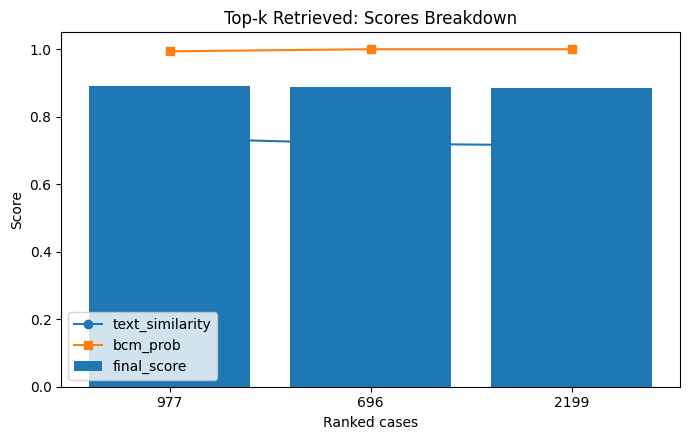

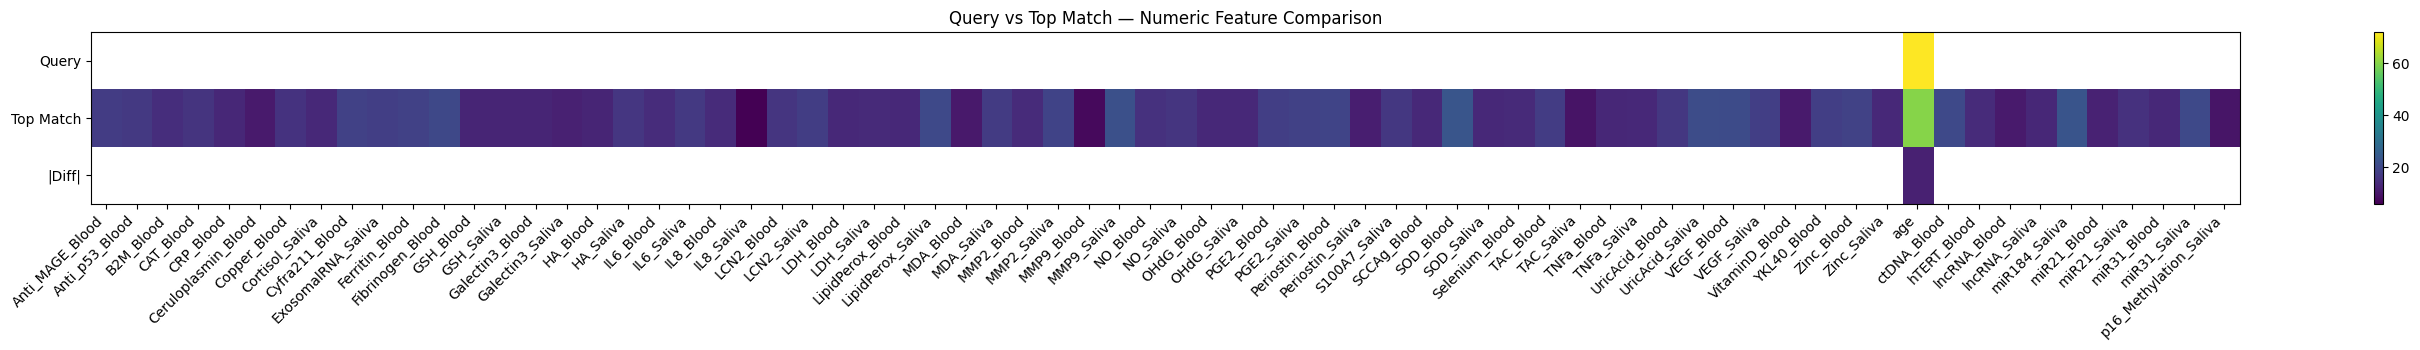

In [11]:
# Global cache for the loaded engine (kept across calls in the notebook session)
_CBR_SYSTEM_STATE = {"engine": None}

def retrieve_cases(new_case: dict, k_final: int = 3) -> Optional[pd.DataFrame]:
    """Retrieve similar cases for a new patient case using persisted models."""
    
    # ---- Step 1: Lazy-load engine ----
    if _CBR_SYSTEM_STATE.get("engine") is None:
        try:
            print("\n" + "-" * 80)
            print("Initializing CBR Engine for Retrieval")
            print("-" * 80)
            engine = load_cbr_engine_from_disk(RESULT_DIR)
            _CBR_SYSTEM_STATE["engine"] = engine
        except FileNotFoundError as e:
            print(f"\n[ERROR] {e}\n")
            return None

    engine = _CBR_SYSTEM_STATE["engine"]

    # ---- Step 2: Convert query dict → Pandas Series ----
    query_series = pd.Series(new_case)

    # Impute missing numeric fields with scaler's observed minima
    # This ensures query values remain in the scaler's training range.
    for i, col in enumerate(engine.structured_cols):
        if pd.isna(query_series.get(col)):
            query_series[col] = float(engine.scaler.data_min_[i])

    # ---- Step 3: Preview query ----
    print("\n" + "-" * 80)
    preview = str(query_series.get(TEXT_COL, "")).strip()[:60].replace("\n", " ")
    print(f'Retrieving cases for query (preview): "{preview}..."')
    print("-" * 80)

    # ---- Step 4: Retrieve & rank cases ----
    retrieved, latency = engine.retrieve_and_rank(query_series, k_final=k_final)
    print(f"\nRetrieval complete in \033[1m{float(latency):.2f} ms\033[0m.")

    # ---- Step 5: Print top match summary ----
    if not retrieved.empty:
        top = retrieved.iloc[0]
        print("\n" + "=" * 30 + " TOP MATCH " + "=" * 30)
        print(f"  Case ID     : {top.name}")
        print(f"  Diagnosis   : {top[TARGET_COL]}")
        print(f"  Final Score : {float(top['final_score']):.3f}")
        print("  Explanation :")
        print("  " + str(top["bcm_explanation"]).replace("\n", "\n  "))
        print("=" * 75 + "\n")
    else:
        print("\n[INFO] No relevant cases found.\n")

    return retrieved

# Example query
new_patient_case = {
    "age": 72,
    "Cyfra21-1": 6.2,
    "MMP9": 710.0,
    "IL-6": 11.0,
    "clinical_narrative": (
        "Elderly patient with history of smoking presents with a large, "
        "painful lesion on the floor of the mouth. Biomarkers are highly elevated."
    ),
}

# ---- Run retrieval ----
retrieved_cases_df = retrieve_cases(new_patient_case, k_final=3)

if retrieved_cases_df is not None:
    # Print retrieved DataFrame
    print("\n" + "=" * 80)
    print("Full Retrieved Cases DataFrame:")
    print("=" * 80)
    try:
        display(retrieved_cases_df)
    except Exception:
        print(retrieved_cases_df)

    # ---- Visuals for retrieval ----
    try:
        plot_retrieved_scores(retrieved_cases_df, k=3)   # Score breakdown
    except Exception as _e:
        print("Retrieved scores plot skipped (unable to render).")

    try:
        plot_rationale_heatmap(new_patient_case, retrieved_cases_df, cbr_engine.structured_cols)
    except Exception as _e:
        print("Rationale heatmap skipped (unable to render).")    

---
## References

### Case-Based Reasoning
[1] A. Aamodt and M. Nygård, “Case-based reasoning in health sciences: Foundations, applications, and recent advances,” Frontiers in Artificial Intelligence, vol. 4, p. 684151, 2021. [Online]. Available: https://doi.org/10.3389/frai.2021.684151

[2] M. H. Goker and K. D. Althoff, “Applying case-based reasoning for medical decision support: Oncology use cases and future directions,” Journal of Healthcare Informatics Research, vol. 3, pp. 467–490, 2019. [Online]. Available: https://doi.org/10.1007/s41666-019-00054-3

### Numerical Computing (Core Infrastructure)

- **NumPy**  
[3] C. R. Harris, K. J. Millman, S. J. van der Walt et al., “Array programming with NumPy,” *Nature*, vol. 585, pp. 357–362, 2020. [Online]. Available: https://doi.org/10.1038/s41586-020-2649-2  

- **SciPy**  
[4] P. Virtanen, R. Gommers, T. E. Oliphant et al., “SciPy 1.0: Fundamental algorithms for scientific computing in Python,” *Nature Methods*, vol. 17, no. 3, pp. 261–272, 2020. [Online]. Available: https://doi.org/10.1038/s41592-019-0686-2  

### Deep Learning & Embedding Models

- **PyTorch (DL Framework)**  
[5] A. Paszke, S. Gross, F. Massa et al., “PyTorch: An imperative style, high-performance deep learning library,” in *Advances in Neural Information Processing Systems (NeurIPS)*, 2019. [Online]. Available: https://papers.neurips.cc/paper/2019/hash/bdbca288fee7f92f2bfa9f7012727740-Abstract.html  

- **Transformers (LLMs)**  
[6] T. Wolf, L. Debut, V. Sanh et al., “Transformers: State-of-the-art natural language processing,” in *Proc. 2020 Conf. Empirical Methods in Natural Language Processing (EMNLP 2020): System Demonstrations*, pp. 38–45, 2020. [Online]. Available: https://doi.org/10.18653/v1/2020.emnlp-demos.6  

- **Sentence-BERT (Embeddings)**  
[7] N. Reimers and I. Gurevych, “Sentence-BERT: Sentence embeddings using Siamese BERT-networks,” in *Proc. 2019 Conf. Empirical Methods in Natural Language Processing (EMNLP 2019)*, pp. 3982–3992, 2019. [Online]. Available: https://doi.org/10.18653/v1/D19-1410  


### Similarity Search & Reasoning Layer

- **FAISS (Billion-Scale Similarity Search)**  
[8] J. Johnson, M. Douze, and H. Jégou, “Billion-scale similarity search with GPUs,” *IEEE Trans. Big Data*, vol. 7, no. 3, pp. 535–547, 2021. [Online]. Available: https://doi.org/10.1109/TBDATA.2019.2921572  

- **PCA (Dimensionality Reduction for BCM reasoning)**  
[9] I. T. Jolliffe and J. Cadima, “Principal component analysis: A review and recent developments,” *Philos. Trans. R. Soc. A*, vol. 374, no. 2065, 2016. [Online]. Available: https://doi.org/10.1098/rsta.2015.0202  

- **Model-Based Clustering (CBR/BCM)**  
[10] I. C. Gormley, T. B. Murphy, and A. E. Raftery, “Model-based clustering,” *Annu. Rev. Stat. Appl.*, vol. 10, pp. 573–595, 2023. [Online]. Available: https://doi.org/10.1146/annurev-statistics-033121-112312  

- **k-means Survey (Prototype Clustering Step)**  
[11] M. Ahmed, R. Seraj, and S. M. S. Islam, “The k-means algorithm: A comprehensive survey and performance evaluation,” *Electronics*, vol. 9, no. 8, p. 1295, 2020. [Online]. Available: https://doi.org/10.3390/electronics9081295  
